# MOwNiT 

## Laboratorium 3

### Interpolacja

Przed uruchomieniem trzeba zainstalować pakiet:

```julia
Pkg.add("Interpolations")
```

In [ ]:
using Plots

In [2]:
# wylosowanie węzłów interpolacji
xs =  1:1:10
ys = [rand() for x in xs]

10-element Array{Float64,1}:
 0.2002783686276597
 0.6220353338960825
 0.5618195501082406
 0.9563130121190335
 0.26143966051476286
 0.24696270693033107
 0.5906995479705561
 0.6438299834732786
 0.7267770290989115
 0.3824534180005983

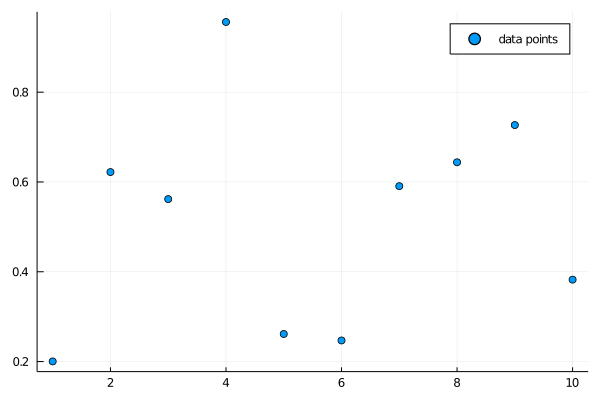

In [3]:
scatter(xs,ys, label="data points")

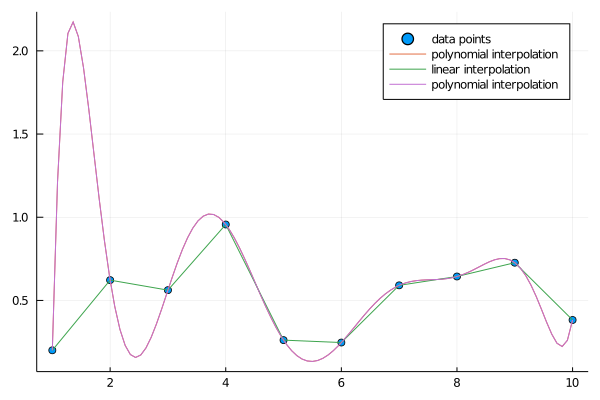

In [7]:
# interpolacja wielomianowa w pakiecie Polynomials
# https://juliamath.github.io/Polynomials.jl/stable/

# Fit a polynomial (of degree deg) to x and y using polynomial interpolation or a (weighted) least-squares approximation.
using Polynomials
f=fit(xs, ys)  # degree = length(xs) - 1 == 9
plot!(f,  extrema(xs)..., label="polynomial interpolation")

In [8]:
# gęste punkty do rysowania wykresów funkcji interpolujacych
xsf=1:0.01:10

1.0:0.01:10.0

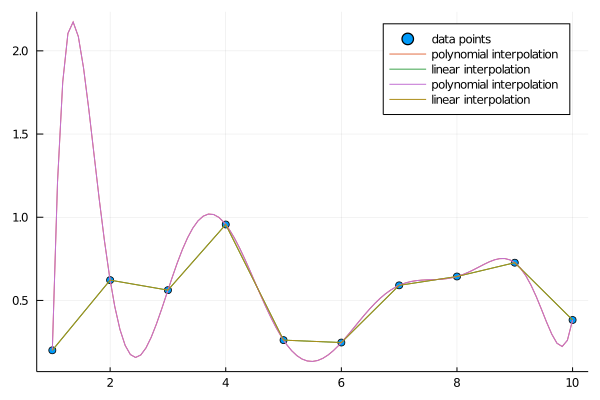

In [9]:
#  interpolacja liniowa z pakietu Interpolations - przykład
using Interpolations
interp_linear = LinearInterpolation(xs, ys)
ysf=[interp_linear(x) for x in xsf]
plot!(xsf,ysf, label="linear interpolation")

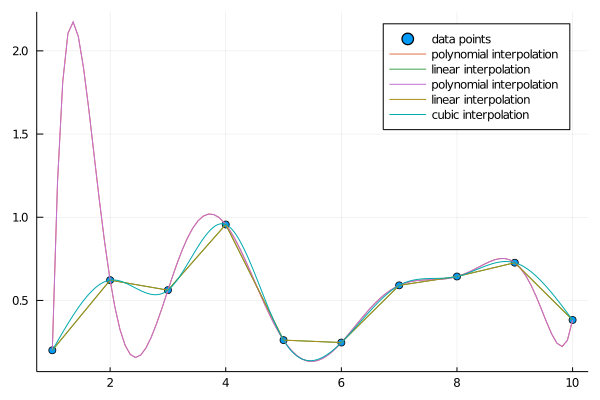

In [10]:
# interpolacja szescienna 
interp_cubic = CubicSplineInterpolation(xs, ys)
ysf2=[interp_cubic(x) for x in xsf]
plot!(xsf,ysf2, label="cubic interpolation")

In [11]:
#Interpolacja szescienna to BSpline z warunkami brzegowymi Line i OnGrid. 
#Więcej o konfiguracji warunkow brzegowych w
# dokumentacji https://github.com/JuliaMath/Interpolations.jl/blob/master/doc/Interpolations_algebra.pdf
interp_cubic

10-element extrapolate(scale(interpolate(OffsetArray(::Array{Float64,1}, 0:11), BSpline(Cubic(Line(OnGrid())))), (1:1:10,)), Throw()) with element type Float64:
 0.20027836862765963
 0.6220353338960823
 0.5618195501082406
 0.9563130121190335
 0.26143966051476286
 0.24696270693033107
 0.5906995479705562
 0.6438299834732787
 0.7267770290989116
 0.3824534180005983

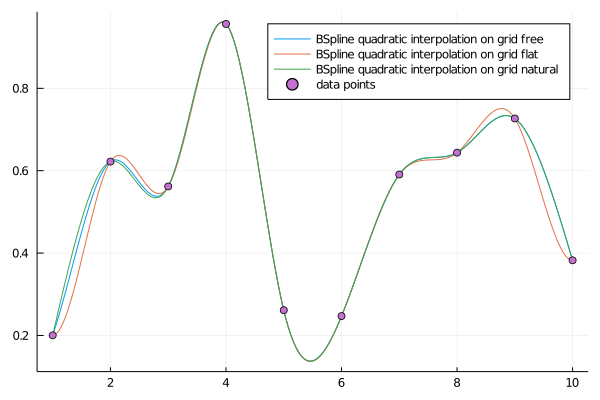

In [12]:
# Przyklad konfiguracji  BSpline-ów
itp = interpolate(ys, BSpline(Cubic(Free(OnGrid()))))
ysf3=[itp(x) for x in xsf]
plot(xsf,ysf3, label="BSpline quadratic interpolation on grid free")
itp = interpolate(ys, BSpline(Cubic(Flat(OnGrid()))))
ysf3=[itp(x) for x in xsf]
plot!(xsf,ysf3, label="BSpline quadratic interpolation on grid flat")
itp = interpolate(ys, BSpline(Cubic(Natural(OnGrid()))))
ysf3=[itp(x) for x in xsf]
plot!(xsf,ysf3, label="BSpline quadratic interpolation on grid natural")

scatter!(xs,ys, label="data points")


### Zadania
1. Napisać własną implementację interpolacji wielomianowej stosując wprost wzór na wielomian interpolacyjny  Lagrange'a .  Przetestować swoją implementację na wylosowanych węzłach interpolacji w wybranym przedziale. Narysować wykres wielomianu interpolacyjnego w tym przedziale wraz z wezlami interpolacji. <b>(1 pkt)</b>

1. Zrobic to samo dla metody  Newtona (metoda ilorazów róznicowych).Narysować wykres wielomianu interpolacyjnego otrzymanego metodą Newtona dla tych samych danych, co w poprzednim punkcie. Zadbać o to, żeby ilorazy wyliczać tylko raz dla danego zbioru wezłow interpolacji, według schematu z pakietu Interpolations http://juliamath.github.io/Interpolations.jl/stable/interpolations/ : 
   1. napisać funkcję `NewtonInterpolation`, która wylicza ilorazy różnicowe i zwraca "obiekt interpolacyjny" `newt`
   1. napisać funkcję która wylicza wartość wielomianu dla obiektu `newt` w punkcie x za pomocą  <b>schematu Hornera dla postaci Newtona </b> <b>(2 pkt)</b>

1. Zastosowac interpolację wielomianową z pakietu Polynomials  do tych samych danych, co w poprzednich punktach. Porównać wszystkie 3 wyniki interpolacji wielomianowej na jednym wykresie. Co zauważamy? Dlaczego? <b>(1 pkt)</b>

1. Porownać  metody poprzez pomiar czasu wykonania dla zmiennej ilości węzłow interpolacji. Uwaga: dodatkowo, dla metody Newtona i pakietu Polynomials należy osobno zmierzyć czas wyliczania wielomianu i osobno czas wyliczania wartości w punkcie. Dokonac pomiaru 10 razy i policzyc wartość średnią oraz oszacować bład pomiaru za pomoca odchylenia standardowego.  Jako narzedzie do analizy danych użyć Julia DataFrames. <b>(2 pkt)</b>

1. Zaimplementować algorytm Neville’a i sprawdzić (dla kilku wybranych punktów), czy daje te same wartości wielomianu co wybrana interpolacja wielomianowa.<b>(1 pkt)</b>

1. Poeksperymentować z  interpolacją funkcjami sklejanymi (minimum dwie różne funkcje sklejane),  narysować wykresy i porównać z wykresami interpolacji wielomianowej. <b>Zademonstrować  efekt Rungego</b> <b>(1 pkt)</b>. 

## Zad 1.
1. Napisać własną implementację interpolacji wielomianowej stosując wprost wzór na wielomian interpolacyjny  Lagrange'a .  Przetestować swoją implementację na wylosowanych węzłach interpolacji w wybranym przedziale. Narysować wykres wielomianu interpolacyjnego w tym przedziale wraz z wezlami interpolacji. <b>(1 pkt)</b>

$P_n(x) = \sum_{k=0}^{n} f(x_k) \cdot L_k(x)$ 

$L_k(x) = \prod_{i=0,i\neq k}^{n} \frac{x-x_i}{x_k-x_i}$

### Implementacja

In [13]:
# y = f(x) = (x - x1)(x - x2)...(x - xn) * y0/(x0 - x1)(x0 - x2)...(x0 - xn) 
#                                  +
#            (x - x0)(x - x2)...(x - xn) * y1/(x1 - x0)(x1 - x2)...(x1 - xn)
#                              + .... +
#            (x - x1)(x - x2)...(x - xn-1) * yn/(xn - x0)(xn - x1)...(xn - xn-1)

function LagrangeInterpolation(xs, ys, x)
    res = 0
    for k in 1:1:length(ys)
        # count yk * Lk(x)
        yk = ys[k]
        Lk = 1
        for i in 1:1:length(xs)
            if i != k
                Lk *= (x - xs[i])/(xs[k] - xs[i]) 
            end
        end
        yk *= Lk
        res += yk
    end
    return res
end
    

LagrangeInterpolation (generic function with 1 method)

### Test

In [26]:
n = 10  # number of points
x_interval = [0 20]
y_interval = [0 30]

xs = [rand()*((x_interval[2] - x_interval[1]) + x_interval[1]) for x in 1:n]
ys = [rand()*((y_interval[2] - y_interval[1]) + y_interval[1]) for y in 1:n]

10-element Array{Float64,1}:
 18.149933931323112
 24.20397162345499
 20.209919725946946
 26.509617920994177
 27.5898976412205
  0.983917831167207
  2.64272112719945
 25.475176621104627
 10.945528399529644
 19.6400068309261

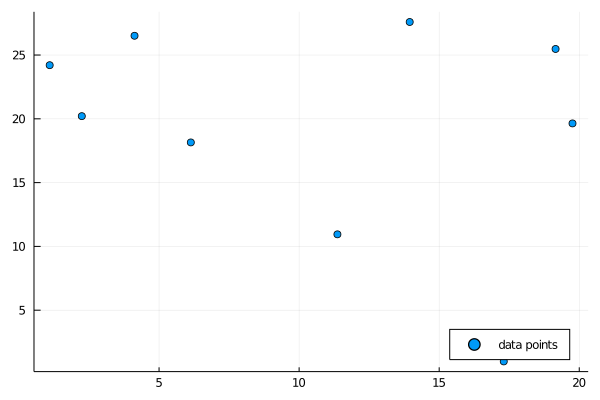

In [32]:
scatter(xs, ys, label = "data points", legend=:bottomright)

In [33]:
xs2 = minimum(xs):0.1:maximum(xs)
ys2 = [LagrangeInterpolation(xs,ys,x) for x in xs2]

187-element Array{Float64,1}:
 24.20397162345499
 26.083069530913185
 27.1146127035085
 27.473166576324765
 27.311464031541906
 26.762206514214938
 25.939764342812055
 24.94177996374918
 23.850677814372688
 22.73508437494744
 21.651161907207616
 20.643859294915437
 19.748083320657084
  ⋮
 21.38169855955379
 22.607316051035106
 23.649789061670244
 24.481779590270015
 25.076944305742312
 25.410408554024052
 25.459287868640455
 25.20325947559419
 24.62518635458175
 23.711796490719653
 22.454420024041852
 20.849787077997863

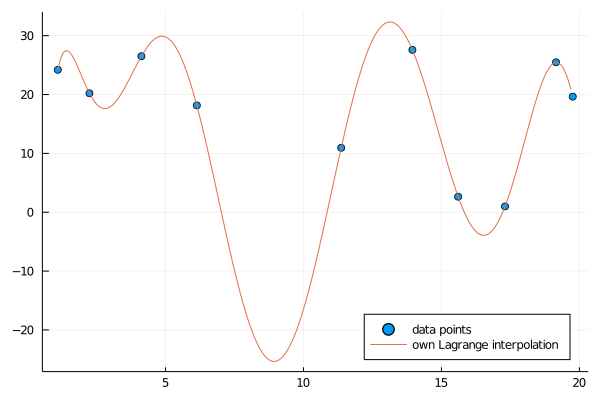

In [34]:
plot!(xs2, ys2, label = "own Lagrange interpolation")

## Zad 2.
Zrobic to samo dla metody  Newtona (metoda ilorazów różnicowych).Narysować wykres wielomianu interpolacyjnego otrzymanego metodą Newtona dla tych samych danych, co w poprzednim punkcie. Zadbać o to, żeby ilorazy wyliczać tylko raz dla danego zbioru wezłow interpolacji, według schematu z pakietu Interpolations http://juliamath.github.io/Interpolations.jl/stable/interpolations/ : 
   1. napisać funkcję `NewtonInterpolation`, która wylicza ilorazy różnicowe i zwraca "obiekt interpolacyjny" `newt`
   2. napisać funkcję która wylicza wartość wielomianu dla obiektu `newt` w punkcie x za pomocą  <b>schematu Hornera dla postaci Newtona </b> <b>(2 pkt)</b>

$P_n(x) = f[x_0] + \sum_{k=1}^{n} f[x_0,x_1,...,x_k](x-x_0)\cdot...\cdot(x-x_{k-1})$

#### Postać Newtona:

$W(x) = \sum_{k=0}^{n} b_kp_k(x)$

$p_0(x) = 1$

$p_k(x) = (x-x_0)(x-x_1)\cdot...\cdot(x-x_{k-1})$

#### Algorytm Hornera dla postaci Newtona:
$W_n = b_n$

$W_i = W_{i+1}\cdot(x-x_i)+b_i$

$W(x) = W_0$

In [35]:
 function NewtonInterpolation(xs,ys)
    n = length(xs)
    matrix = zeros(n,n)
    
    # first col
    for row in 1:1:n
        matrix[row,1] = ys[row]
    end
    
    for col in 2:1:n
        for row in col:n
            matrix[row,col] = (matrix[row,col-1] - matrix[row-1,col-1])/(xs[row] - xs[row-col+1])
        end
    end
    
    newt = zeros(n)
    for i in 1:1:n
        newt[i] = matrix[i,i]
    end
    
    return newt
end

NewtonInterpolation (generic function with 1 method)

In [36]:
newt = NewtonInterpolation(xs,ys)

10-element Array{Float64,1}:
 18.149933931323112
 -1.2015380184586173
  0.5862363093324697
 -0.8302574956095239
  0.08105467425422894
 -0.006290228665590127
  0.0008253360622238426
 -8.575131793195444e-5
 -1.9758019802813025e-5
  2.4577916253979378e-6

In [37]:
function CalculateValue(newt,xs,x)
    n = length(xs)
    W = newt[n]
    for i in n-1:-1:1
        W = W*(x - xs[i]) + newt[i]
    end
    return W    
end

CalculateValue (generic function with 1 method)

In [38]:
xs3 = minimum(xs):0.1:maximum(xs)
ys3 = [CalculateValue(newt, xs, x) for x in xs3]

187-element Array{Float64,1}:
 24.20397162345499
 26.083069530913185
 27.114612703508516
 27.473166576324765
 27.31146403154191
 26.762206514214945
 25.93976434281205
 24.941779963749205
 23.850677814372688
 22.735084374947455
 21.651161907207626
 20.643859294915433
 19.748083320657095
  ⋮
 21.381698559553474
 22.607316051034726
 23.649789061670297
 24.48177959026993
 25.076944305741936
 25.410408554023864
 25.45928786864026
 25.203259475593963
 24.625186354581853
 23.71179649071936
 22.45442002404166
 20.84978707799751

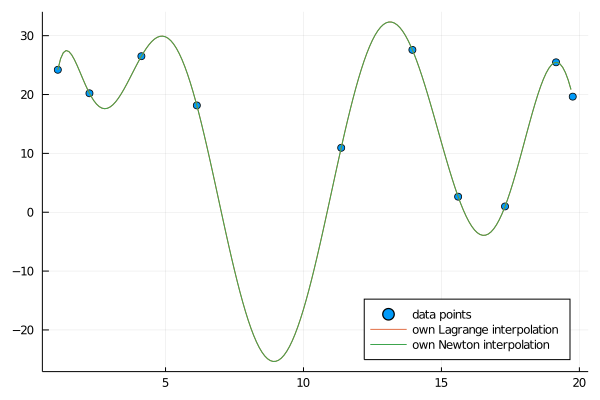

In [39]:
plot!(xs3, ys3, label = "own Newton interpolation")

## Zad 3.
Zastosowac interpolację wielomianową z pakietu Polynomials  do tych samych danych, co w poprzednich punktach. Porównać wszystkie 3 wyniki interpolacji wielomianowej na jednym wykresie. Co zauważamy? Dlaczego? <b>(1 pkt)</b>

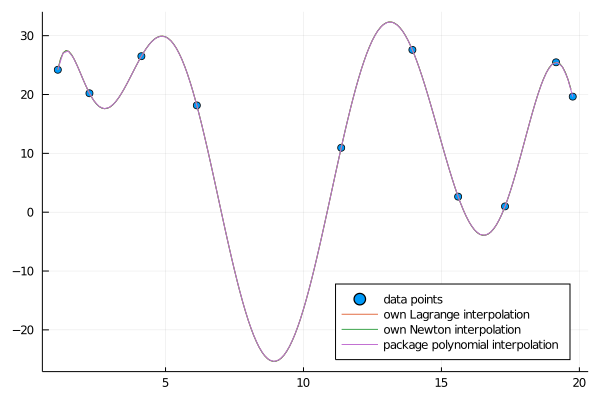

In [40]:
f=fit(xs, ys)  # degree = length(xs) - 1 == 9
plot!(f,  extrema(xs)..., label="package polynomial interpolation")


### Obserwacje:
Wszystkie 3 wyniki interpolacji są takie same, co widać na wykresie - krzywe nakładają sie na siebie. Wynika to z tego, że każda z metod wyznacza wielomian interpolujący jednoznacznie.

## Zad 4. 
Porownać  metody poprzez pomiar czasu wykonania dla zmiennej ilości węzłow interpolacji. Uwaga: dodatkowo, dla metody Newtona i pakietu Polynomials należy osobno zmierzyć czas wyliczania wielomianu i osobno czas wyliczania wartości w punkcie. Dokonac pomiaru 10 razy i policzyc wartość średnią oraz oszacować bład pomiaru za pomoca odchylenia standardowego.  Jako narzedzie do analizy danych użyć Julia DataFrames. <b>(2 pkt)</b>

In [41]:
# polyfit, polyval from Polynomials package
# https://juliamath.github.io/Polynomials.jl/v0.4/
# ???

using Polynomials
using DataFrames

res = DataFrame(size = Int64[], i = Int64[], Lagrange = Float64[], polynomials = Float64[], Newton = Float64[], 
                Newton_pol = Float64[], Newton_val = Float64[])

for size in 20:20:260
    xs =  1:1:size
    ys = [rand() for x in xs]
    
    for i in 1:1:10
        xs2 = 1:0.1:size
        Lagrange = @elapsed [LagrangeInterpolation(xs,ys,x) for x in xs2]
        Newton_pol = @elapsed newt = NewtonInterpolation(xs,ys)
        Newton_val = @elapsed [CalculateValue(newt, xs, x) for x in xs2]
        Newton = Newton_pol + Newton_val
        polynomials = @elapsed fit(xs, ys)

        push!(res, [size i Lagrange polynomials Newton Newton_pol Newton_val])
    end
end

In [42]:
using Statistics
res_grouped = combine(groupby(res, :size), "Lagrange" => mean, "polynomials" => mean, "Newton" => mean,
                                           "Lagrange" => std, "polynomials" => std, "Newton" => std)

,size,Lagrange_mean,polynomials_mean,Newton_mean,Lagrange_std,polynomials_std
,Int64,Float64,Float64,Float64,Float64,Float64
1,20,0.00787351,3.8998e-6,0.0106744,0.0237876,3.20948e-6
2,40,0.00248546,4.9399e-6,6.314e-5,1.4231e-5,1.35232e-6
3,60,0.00813704,9.0898e-6,0.00012972,5.62417e-5,1.0919e-6
4,80,0.0190454,1.64499e-5,0.00021613,7.68736e-5,1.27835e-6
5,100,0.0369191,2.30897e-5,0.000327361,0.000137108,7.96056e-7
6,120,0.0633073,2.95302e-5,0.000464641,0.000140158,1.02008e-6
7,140,0.0999649,3.59099e-5,0.00064745,0.000224431,1.51596e-6
8,160,0.148624,4.37798e-5,0.000831921,0.000113736,1.20051e-6
9,180,0.211121,5.295e-5,0.00102408,0.000125505,1.4864e-6


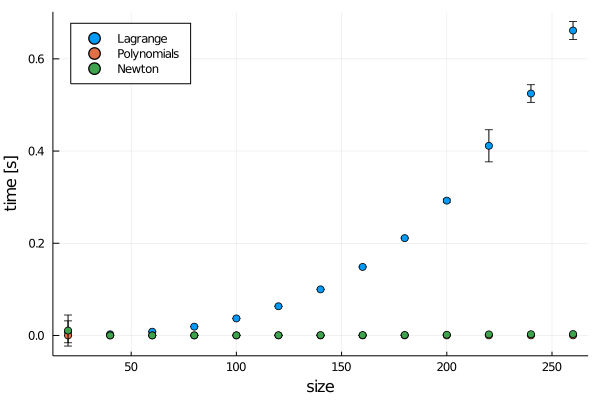

In [43]:
using Plots
scatter(res_grouped.size, res_grouped.Lagrange_mean, yerr=res_grouped.Lagrange_std, label = "Lagrange", 
        xlabel = "size", ylabel = "time [s]", legend=:topleft)
scatter!(res_grouped.size, res_grouped.polynomials_mean, yerr=res_grouped.polynomials_std, label = "Polynomials")
scatter!(res_grouped.size, res_grouped.Newton_mean, yerr=res_grouped.Newton_std, label ="Newton")

Najwolniejsza okazała się interpolacja Lagrange'a, pozostałe dwie metody są znacznie szybsze.

Popatrzmy jeszcze na wykres tylko dla metod Newtona i wielomianowej.

In [44]:
using Polynomials
using DataFrames

res = DataFrame(size = Int64[], i = Int64[], polynomials = Float64[], Newton = Float64[])

for size in 200:40:1400
    xs =  1:1:size
    ys = [rand() for x in xs]
    
    for i in 1:1:10
        xs2 = 1:0.1:size
        Newton_pol = @elapsed newt = NewtonInterpolation(xs,ys)
        Newton_val = @elapsed [CalculateValue(newt, xs, x) for x in xs2]
        Newton = Newton_pol + Newton_val
        polynomials = @elapsed fit(xs, ys)

        push!(res, [size i polynomials Newton])
    end
end

In [45]:
using Statistics
res_grouped = combine(groupby(res, :size), "polynomials" => mean, "Newton" => mean,
                                           "polynomials" => std, "Newton" => std) 

,size,polynomials_mean,Newton_mean,polynomials_std,Newton_std
,Int64,Float64,Float64,Float64,Float64
1,200,7.71802e-5,0.00563762,3.22881e-6,0.0131617
2,240,0.00013772,0.00257184,2.73647e-6,3.38767e-5
3,280,0.00018266,0.00329307,1.14404e-6,1.52679e-5
4,320,0.00023138,0.00415237,3.50665e-6,5.99418e-5
5,360,0.00028977,0.00511511,6.43994e-6,3.22422e-5
6,400,0.00034296,0.00931398,8.2795e-6,0.0103325
7,440,0.00040741,0.00725234,8.28778e-6,8.77034e-5
8,480,0.00046761,0.00859776,2.75487e-6,0.000113911
9,520,0.00053884,0.00988517,7.2014e-6,6.68922e-5


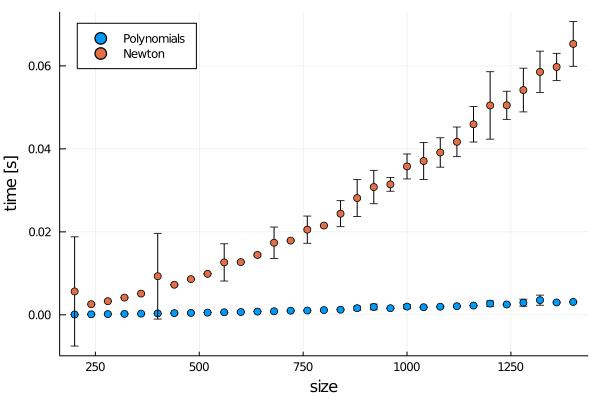

In [46]:
using Plots
scatter(res_grouped.size, res_grouped.polynomials_mean, yerr=res_grouped.polynomials_std, label = "Polynomials",
        xlabel = "size", ylabel = "time [s]", legend=:topleft)
scatter!(res_grouped.size, res_grouped.Newton_mean, yerr=res_grouped.Newton_std, label ="Newton")

Porównując te dwie metody, możemy zauważyć, że metoda wielomianowa jest najszybsza z testowanych.

## Zad 5.
Zaimplementować algorytm Neville’a i sprawdzić (dla kilku wybranych punktów), czy daje te same wartości wielomianu co wybrana interpolacja wielomianowa.<b>(1 pkt)</b>

 Algorytm ten jest używany do wyznaczania wartości wielomianu interpolacyjnego (Lagrange’a i Newtona) w danym punkcie $x$.

In [47]:
function NevilleAlgorithm(xs,ys,x)
    n = length(xs)
    t = zeros(n)
    for i in 1:1:n
        t[i] = ys[i]
        for j in i-1:-1:1
        t[j] = t[j+1] + (t[j+1] - t[j]) * (x - xs[i])/(xs[i] - xs[j])
        end
    end
  return t[1]  
end

NevilleAlgorithm (generic function with 1 method)

In [48]:
n = 6  # number of points
x_interval = [0 10]
y_interval = [0 10]

xs = [rand()*((x_interval[2] - x_interval[1]) + x_interval[1]) for x in 1:n]
ys = [rand()*((y_interval[2] - y_interval[1]) + y_interval[1]) for y in 1:n]

6-element Array{Float64,1}:
 5.355346386062472
 0.12947843640288115
 6.67609250757682
 0.9121376644336077
 0.12180113138227755
 8.154604410386552

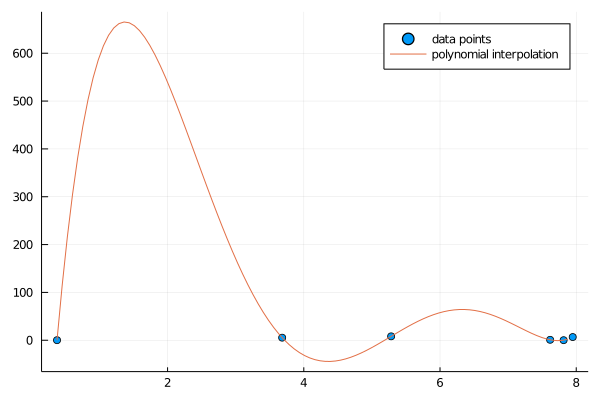

In [49]:
scatter(xs, ys, label = "data points")
f=fit(xs, ys)  # degree = length(xs) - 1 == 9
plot!(f,  extrema(xs)..., label="polynomial interpolation")

In [50]:
xs3 = minimum(xs):0.1:maximum(xs)
ys3 = [NevilleAlgorithm(xs, ys, x) for x in xs3]

76-element Array{Float64,1}:
   0.12947843639971038
 148.52471687545795
 273.9468573204533
 378.3531105645965
 463.6037723890954
 531.4644401877322
 583.6082295913909
 621.6179910925568
 646.9885266698714
 661.1288064126652
 665.3641851454579
 660.938619052522
 649.0168823023896
   ⋮
  52.097349368423224
  46.47424358890884
  40.1123108432283
  33.23491620981165
  26.11037372500025
  19.05416300757631
  12.431145883291755
   6.657783009397833
   2.204350499174596
  -0.40284345353990697
  -0.5792419498200604
   2.3201772388763837

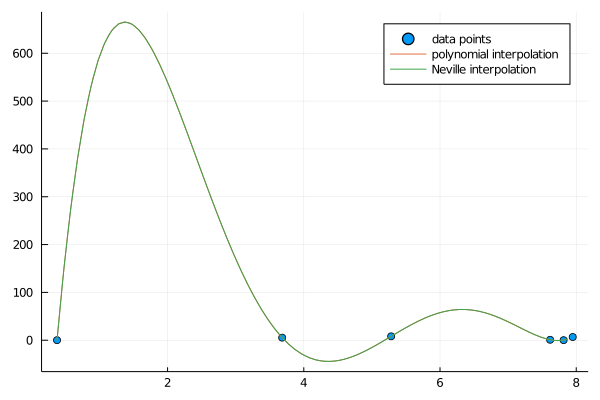

In [51]:
plot!(xs3, ys3, label = "Neville interpolation")

Algorytm Nevilla daje te same wyniki, co interpolacja wielomianowa z pakietu Polynomial - na powyższym wykresie widać, ze krzywe nałożyły sie na siebie.

## Zad 6.
Poeksperymentować z  interpolacją funkcjami sklejanymi (minimum dwie różne funkcje sklejane),  narysować wykresy i porównać z wykresami interpolacji wielomianowej. <b>Zademonstrować  efekt Rungego</b> <b>(1 pkt)</b>. 

In [55]:
xs =  1:1:6
ys = [rand() for x in xs]

xs2 = 1:0.1:6

1.0:0.1:6.0

In [56]:
quad = interpolate(ys, BSpline(Quadratic(Line(OnCell()))))
quad_ys = [quad(x) for x in xs2]

cub = CubicSplineInterpolation(xs, ys)
cub_ys = [cub(x) for x in xs2]

cub2 = interpolate(ys, BSpline(Cubic(Free(OnGrid()))))
cub_ys2 = [cub2(x) for x in xs2]

f=fit(xs, ys) 

Polynomial(1.7917735588971784 - 6.110295246864174*x + 6.736143541755897*x^2 - 2.831401525625675*x^3 + 0.5047666364941117*x^4 - 0.03214753881235309*x^5)

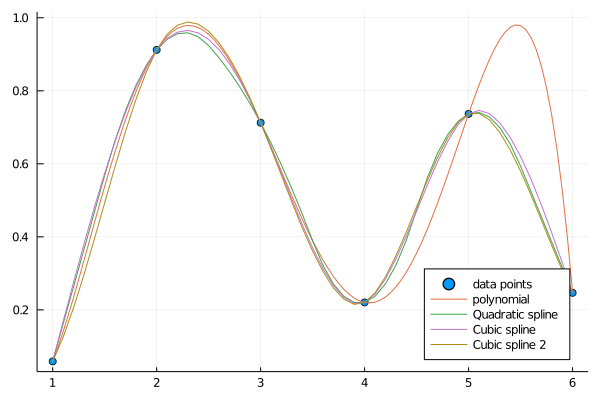

In [57]:
scatter(xs, ys, label = "data points", legend=:bottomright)
plot!(f,  extrema(xs)..., label="polynomial")
plot!(xs2, quad_ys, label = "Quadratic spline")
plot!(xs2, cub_ys, label = "Cubic spline")
plot!(xs2, cub_ys2, label = "Cubic spline 2")

Interpolacja funkcjami sklejanymi stopnia 2 czy 3 ma podobne rezultaty. Wyraźnie odstaje interpolacja wielomianowa.

#### Efekt Rungego

Pogorszenie jakości interpolacji wielomianowej, mimo zwiększenia liczby jej węzłów.
Takie zachowanie się wielomianu interpolującego jest zjawiskiem typowym dla interpolacji za pomocą wielomianów wysokich stopni przy stałych odległościach węzłów. Występuje ono również, jeśli interpolowana funkcja jest nieciągła albo odbiega znacząco od funkcji gładkiej.

Dla przykładu sprawdzimy wielomian stopnia 15, węzły równoodległe.

In [58]:
xs =  1:1:15
ys = [rand() for x in xs]
xs2 = 1:0.1:15

1.0:0.1:15.0

In [59]:
f=fit(xs, ys)

Polynomial(-6928.5259711007775 + 21946.396092419716*x - 29364.615960096282*x^2 + 22381.573984474915*x^3 - 10986.982117980879*x^4 + 3707.236041836746*x^5 - 892.752546968556*x^6 + 156.71845797743862*x^7 - 20.242480264896393*x^8 + 1.921591882416877*x^9 - 0.132387591313159*x^10 + 0.006436414921955292*x^11 - 0.00020924795293727322*x^12 + 4.0802104529278455e-6*x^13 - 3.6070500322916e-8*x^14)

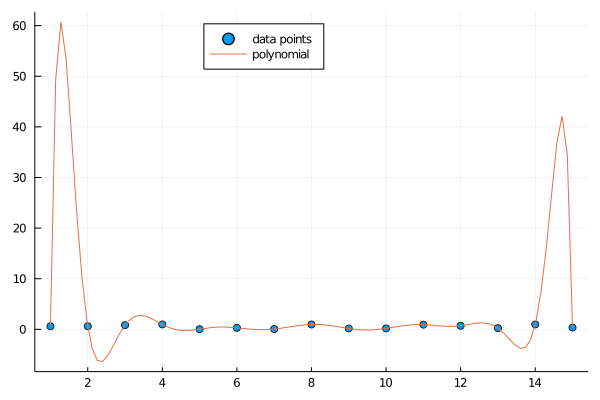

In [60]:
scatter(xs, ys, label = "data points", legend=:top)
plot!(f,  extrema(xs)..., label="polynomial")